In [17]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sys.path.append("C:\\Users\\zuk-8\\Programs\\workspace\\fantacalcio\\src")
# sys.path.append("C:\\Users\\zuk-8\\Programs\\workspace\\fantacalcio\\src\\fantacalcio")
# sys.path.append("C:\\Users\\zuk-8\\Programs\\workspace\\fantacalcio\\src\\fantacalcio\\config_data")
# sys.path.append("C:\\Users\\zuk-8\\Programs\\workspace\\fantacalcio\\src\\fantacalcio\\data")

from fantacalcio.config_data.config_data import FOLDER_FANTA_INPUT, FANTA_GRADES_FN, FANTA_REMAP_FN
from fantacalcio.data.general import canceled_matches_grades_to_nan, remap_players
from fantacalcio.data.player import Player

In [49]:
# INPUTS
average_grades_by_role = pd.Series({'P':4.5, 'D':5.5, 'C':5.75, 'T':6.2, 'A':6.4})

In [18]:
# DATA
GRADES = canceled_matches_grades_to_nan(pd.read_csv(os.path.join(FOLDER_FANTA_INPUT[os.environ['USERNAME']], FANTA_GRADES_FN)))
REMAP_PLAYERS = pd.read_csv(os.path.join(FOLDER_FANTA_INPUT[os.environ['USERNAME']], FANTA_REMAP_FN)).set_index('Original')['Final'].to_dict()
GRADES = remap_players(GRADES, REMAP_PLAYERS)

# Penalties:
# 'R'  is the number of scored penalties
# 'RS' is the number of missed penalties, only for players and not for gks
penalty_y = GRADES.ix[~GRADES['R'].map(pd.np.isnan)]
penalty_n = GRADES.ix[~GRADES['RS'].map(pd.np.isnan)]
GRADES = GRADES.set_value(penalty_y.index, col=['FantaVoto'], value=penalty_y['FantaVoto']-penalty_y['R']*3)
GRADES = GRADES.set_value(penalty_n.index, col=['FantaVoto'], value=penalty_y['FantaVoto']+penalty_y['RS']*3)


In [111]:
matches = GRADES.reset_index().groupby(['Season', 'Player'])['FantaVoto'].count().to_frame('Matches')
no_matches = (38 - matches['Matches']).to_frame('No_Matches')
fv_grades = GRADES.reset_index().groupby(['Season', 'Player'])['FantaVoto'].mean().to_frame('Mean_FV')
v_grades = GRADES.reset_index().groupby(['Season', 'Player'])['Voto'].mean().to_frame('Mean_V')
fv_grades_tot = GRADES.reset_index().groupby(['Season', 'Player'])['FantaVoto'].sum().to_frame('Total_FV')
players = GRADES.reset_index()['Player'].unique()
roles_by_seas = GRADES.reset_index().sort_values(['Season', 'Giornata']).groupby(['Season', 'Player'])['Role'].last().to_frame('Role')
roles = roles_by_seas.reset_index().groupby('Player')['Role'].last().to_frame('Role')
roles['Role'] = roles['Role'].map(lambda x:'A' if x=='T' else x)

nm = no_matches.reset_index()
nm['avg'] = nm.Player.map(roles['Role']).map(average_grades_by_role)
nm = nm.set_index(['Season', 'Player'])
average_score = ((nm['No_Matches'] * nm['avg'] + fv_grades_tot['Total_FV'])/38.).to_frame('average_score')

penalty_by_team_all = GRADES.reset_index().query("Role != 'P'").groupby(['Season', 'Team'])[['R', 'RS']].sum().fillna(0)
penalty_by_team = (penalty_by_team_all['R']+penalty_by_team_all['RS']).to_frame('team_penalties')
team_players = GRADES.reset_index().sort_values(['Season', 'Giornata']).groupby(['Season', 'Player']).last()['Team']
penalty_by_team_for_players = team_players.reset_index()\
    .merge(penalty_by_team.reset_index(), left_on=['Season', 'Team'], right_on=['Season', 'Team'])\
    .set_index(['Season', 'Player'])['team_penalties']
penalties_by_player = GRADES.reset_index().fillna(0).groupby(['Season', 'Player'])[['R', 'RS']].sum()
total_penalties = penalties_by_player.sum(1).to_frame('Penalties_Kicked')
percentage_penalties_scored = (penalties_by_player['R']/total_penalties['Penalties_Kicked']).to_frame('Percentage_Penalties_Scored')
percentage_team_penalties_kicked = (total_penalties['Penalties_Kicked'] / penalty_by_team_for_players).to_frame('Percentage_Team_Penalties_Kicked')


In [112]:
scores = matches.join(fv_grades, how='outer').join(average_score, how='outer').join(v_grades, how='outer')\
    .join(total_penalties, how='outer').join(percentage_penalties_scored, how='outer').join(percentage_team_penalties_kicked, how='outer')\
    .reset_index().merge(roles.reset_index(), how='outer', left_on='Player', right_on='Player')\
    .sort_values(['Season', 'Role', 'average_score']).set_index(['Season', 'Role', 'Player'])
scores.to_clipboard()

,Matches,Voto,FantaVoto
Season,,,
2014,33,6.354839,5.909091
2015,35,6.366667,5.900000
2016,29,6.107143,5.275862


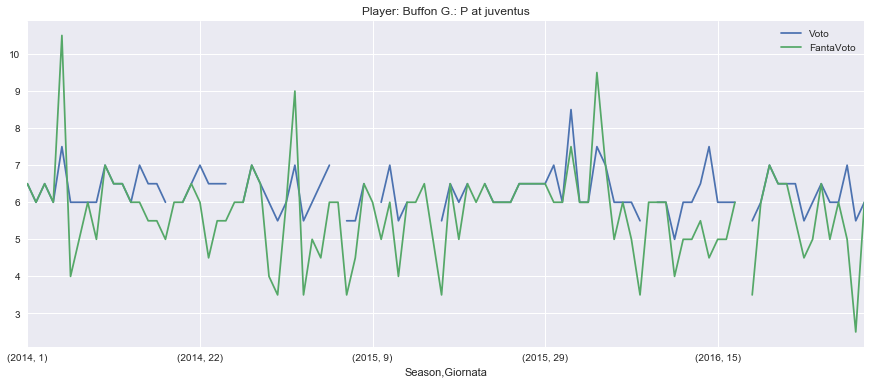

In [124]:
# pl = Player('Dzeko E.')
pl = Player('Buffon G.')
pl.plot(['Voto', 'FantaVoto'], figsize=(15,6))
ma = pl.all_grades.reset_index().groupby('Season')['FantaVoto'].count().to_frame('Matches')
gr = pl.all_grades.reset_index().groupby('Season').mean()[['Voto', 'FantaVoto']]
ma.join(gr)